To decompress the compressed files and save it in the file directory

In [5]:
import bz2
import shutil
import os
import time 


input_train_file = 'train.ft.txt.bz2'
output_train_file = 'train.ft.txt'
input_test_file = 'test.ft.txt.bz2'
output_test_file = 'test.ft.txt'


def decompress_bz2(input_path, output_path):
    if not os.path.exists(output_path) and os.path.exists(input_path):
        print(f"Decompressing {input_path}...")
        try:
            with bz2.open(input_path, 'rb') as f_in, open(output_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
            print(f"{output_path} decompressed successfully.")
            time.sleep(1) 
        except Exception as e:
            print(f"Error decompressing {input_path}: {e}")
    else:
        print(f"{output_path} already exists or {input_path} not found. Skipping decompression.")

decompress_bz2(input_train_file, output_train_file)
decompress_bz2(input_test_file, output_test_file)


train.ft.txt already exists or train.ft.txt.bz2 not found. Skipping decompression.
test.ft.txt already exists or test.ft.txt.bz2 not found. Skipping decompression.


Load, Preprocess, Converts labels and basic EDA


In [6]:
import pandas as pd
import re
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
import time 

def load_data(file_path, retries=5, delay=2):

    labels = []
    reviews = []
    for i in range(retries):
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                for line in file:
                    label, review = line.split(' ', 1)
                    labels.append(label.strip())
                    reviews.append(review.strip())
            return pd.DataFrame({'label': labels, 'review': reviews})
        except PermissionError as e:
            print(f"PermissionError: {e}. Retrying in {delay} seconds... (Attempt {i+1}/{retries})")
            time.sleep(delay)
        except Exception as e:
            print(f"An unexpected error occurred while loading {file_path}: {e}")
            raise
    raise PermissionError(f"Failed to load data from {file_path} after {retries} attempts due to PermissionError.")

print("Loading and preprocessing training data...")
df_train = load_data('train.ft.txt').sample(frac=0.4, random_state=42)

df_train['label'] = df_train['label'].map({'__label__2': 1, '__label__1': 0})

def clean_text(text):
    """
    Cleans text by converting to lowercase and removing non-alphanumeric characters.
    """
    text = re.sub(r'[^A-Za-z0-9\s]', '', text.lower())
    return text

df_train['cleaned_review'] = df_train['review'].apply(clean_text)

df_train['review_length'] = df_train['cleaned_review'].apply(lambda x: len(x.split()))

df_train = df_train.drop(['review'], axis=1)
print("Training data preprocessing complete.")

print("Loading and preprocessing test data...")
df_test = load_data('test.ft.txt').sample(frac=0.4, random_state=42)

df_test['label'] = df_test['label'].map({'__label__2': 1, '__label__1': 0})

df_test['cleaned_review'] = df_test['review'].apply(clean_text)

df_test['review_length'] = df_test['cleaned_review'].apply(lambda x: len(x.split()))

df_test = df_test.drop(['review'], axis=1)
print("Test data preprocessing complete.")


print("Sample of preprocessed training data:")
print(df_train.head())


print("Sample of preprocessed test data:")
print(df_test.head())

print("\n--- Training Data Statistics ---")
print(f"Total number of reviews: {len(df_train)}")
print(f"Number of positive reviews: {df_train['label'].sum()}")
print(f"Number of negative reviews: {len(df_train) - df_train['label'].sum()}")
print(f"Average review length (words): {df_train['review_length'].mean():.2f}")
print(f"Median review length (words): {df_train['review_length'].median()}")
print(f"Max review length (words): {df_train['review_length'].max()}")
print(f"Min review length (words): {df_train['review_length'].min()}")


print("\n--- Test Data Statistics ---")
print(f"Total number of reviews: {len(df_test)}")
print(f"Number of positive reviews: {df_test['label'].sum()}")
print(f"Number of negative reviews: {len(df_test) - df_test['label'].sum()}")
print(f"Average review length (words): {df_test['review_length'].mean():.2f}")
print(f"Median review length (words): {df_test['review_length'].median()}")
print(f"Max review length (words): {df_test['review_length'].max()}")
print(f"Min review length (words): {df_test['review_length'].min()}")


Loading and preprocessing training data...
Training data preprocessing complete.
Loading and preprocessing test data...
Test data preprocessing complete.
Sample of preprocessed training data:
         label                                     cleaned_review  \
2079998      0  expensive junk this product consists of a piec...   
1443106      0  toast too dark even on the lowest setting the ...   
3463669      1  excellent imagerydumbed down story i enjoyed t...   
2914699      0  are we pretending everyone is married the auth...   
1603231      0  not worth your time might as well just use a k...   

         review_length  
2079998            101  
1443106             39  
3463669             70  
2914699             65  
1603231             25  
Sample of preprocessed test data:
        label                                     cleaned_review  \
23218       1  this is a great book i must preface this by sa...   
20731       0  huge disappointment as a big time long term tr...   
39555

EDA - Length distribution, Class distribution, and generating a word cloud.

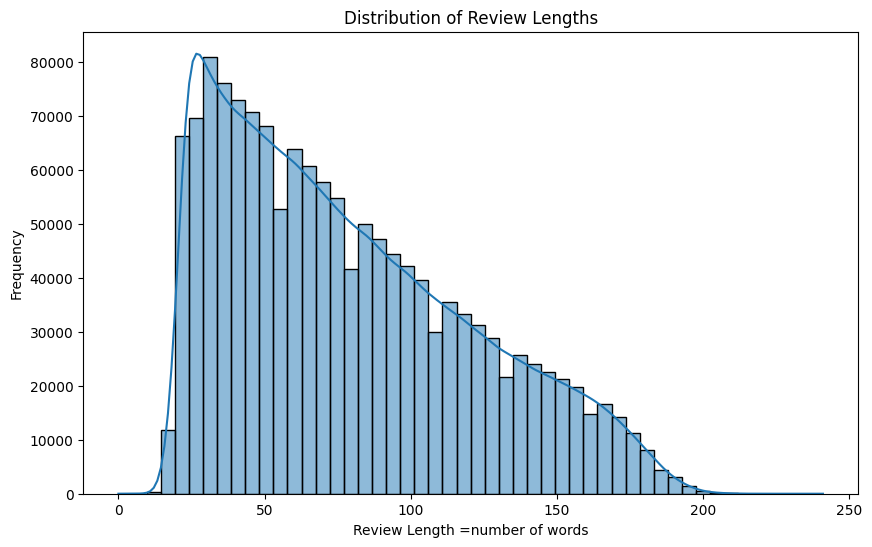

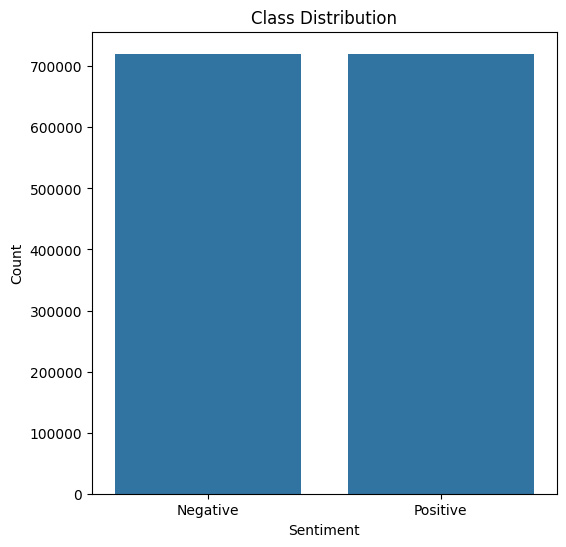

Generating Word Cloud


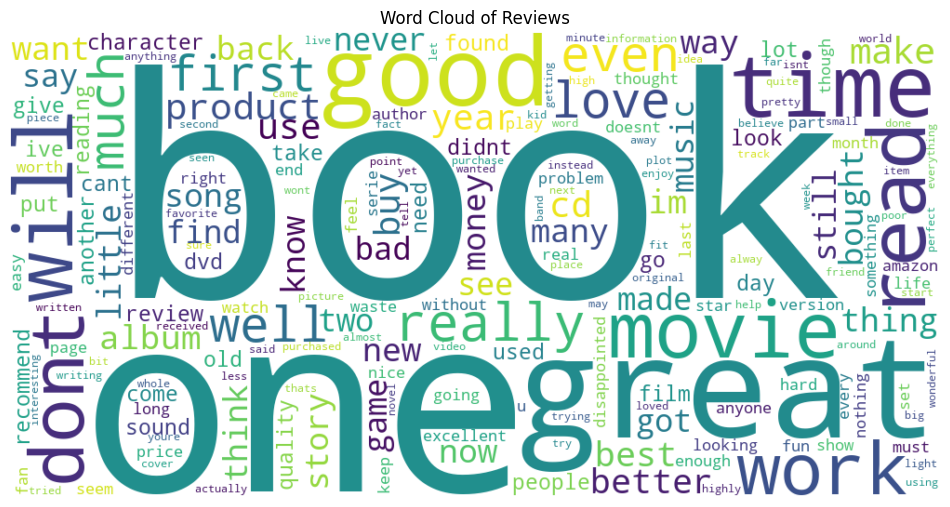

In [7]:

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


plt.figure(figsize=(10, 6))
sns.histplot(df_train['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length =number of words')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6, 6))
sns.countplot(x='label', data=df_train)
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()

print("Generating Word Cloud")

sample_size_wordcloud = min(150000, len(df_train))
all_text = ' '.join(df_train.sample(sample_size_wordcloud, random_state=42)['cleaned_review'])
wordcloud = WordCloud(width=1000, height=500, background_color='white', collocations=False).generate(all_text)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()



Data Preparation for model training - Tokenization, Text to integer sequencing, Padding, Data splitting.

In [8]:

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):

    for text in data_iter:
        yield tokenizer(text)

print("Building vocabulary")
vocab = build_vocab_from_iterator(yield_tokens(df_train['cleaned_review']), specials=["<unk>"], min_freq=5)
vocab.set_default_index(vocab["<unk>"])
print(f"Vocabulary size: {len(vocab)}")

def text_pipeline(x):

    return vocab(tokenizer(x))


print("Tokenizing and converting reviews to numerical sequence")
df_train['tokenized'] = df_train['cleaned_review'].apply(text_pipeline)
df_test['tokenized'] = df_test['cleaned_review'].apply(text_pipeline)

def pad_sequences(sequences, max_length):

    filtered_sequences = [seq for seq in sequences if len(seq) > 0]

    padded_sequences = pad_sequence([torch.tensor(seq[:max_length], dtype=torch.long) for seq in filtered_sequences], batch_first=True, padding_value=vocab['<unk>'])
    return padded_sequences

max_length = 100  
print(f"Padding sequences to a maximum length of {max_length}...")

X_train_raw = df_train['tokenized'].tolist()
y_train_raw = df_train['label'].tolist()

valid_indices_train = [i for i, seq in enumerate(X_train_raw) if len(seq) > 0]
X_train_filtered = [X_train_raw[i] for i in valid_indices_train]
y_train_filtered = [y_train_raw[i] for i in valid_indices_train]

X_train = pad_sequences(X_train_filtered, max_length)
y_train = torch.tensor(y_train_filtered, dtype=torch.long)


X_test_raw = df_test['tokenized'].tolist()
y_test_raw = df_test['label'].tolist()

valid_indices_test = [i for i, seq in enumerate(X_test_raw) if len(seq) > 0]
X_test_filtered = [X_test_raw[i] for i in valid_indices_test]
y_test_filtered = [y_test_raw[i] for i in valid_indices_test]

X_test = pad_sequences(X_test_filtered, max_length)
y_test = torch.tensor(y_test_filtered, dtype=torch.long)


print("Splitting training data into training and validation sets")
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.11, random_state=42, stratify=y_train)

print(f"Shape of X_train_final: {X_train_final.shape}")
print(f"Shape of y_train_final: {y_train_final.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")


from torch.utils.data import DataLoader, TensorDataset


BATCH_SIZE = 1024 

train_dataset = TensorDataset(X_train_final, y_train_final)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

del df_train, df_test, X_train_raw, y_train_raw, X_test_raw, y_test_raw
del X_train, y_train
import gc
gc.collect()
torch.cuda.empty_cache()

Building vocabulary
Vocabulary size: 156853
Tokenizing and converting reviews to numerical sequence
Padding sequences to a maximum length of 100...
Splitting training data into training and validation sets
Shape of X_train_final: torch.Size([1281599, 100])
Shape of y_train_final: torch.Size([1281599])
Shape of X_val: torch.Size([158400, 100])
Shape of y_val: torch.Size([158400])
Shape of X_test: torch.Size([160000, 100])
Shape of y_test: torch.Size([160000])
Number of training batches: 1252
Number of validation batches: 155
Number of test batches: 157


Defining Basic LSTM Model

In [9]:

import torch.nn as nn

class BasicLSTMModel(nn.Module):

    def __init__(self, vocab_size, embed_size, hidden_size, num_classes, num_layers=3, dropout=0.5):
        super(BasicLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
 
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes) 
        self.dropout_layer = nn.Dropout(dropout) 
        self.num_layers = num_layers
        self.hidden_size = hidden_size

    def forward(self, x):

        embedded = self.embedding(x)

        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, (h_n, c_n) = self.lstm(embedded, (h_0, c_0))

        last_hidden_state = out[:, -1, :]

        dropped_out = self.dropout_layer(last_hidden_state)

        logits = self.fc(dropped_out)

        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


Continuation - Further defining the model, Training and validation function, Test-Eval function, Training 2 LSTM variants and selecting the best model.

Epoch 1/3 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 1/3 [Validation]:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch [1/3], Train Loss: 0.4406, Train Acc: 0.7647, Val Loss: 0.2156, Val Acc: 0.9141


Epoch 2/3 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 2/3 [Validation]:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch [2/3], Train Loss: 0.1895, Train Acc: 0.9265, Val Loss: 0.1758, Val Acc: 0.9310


Epoch 3/3 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 3/3 [Validation]:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch [3/3], Train Loss: 0.1573, Train Acc: 0.9408, Val Loss: 0.1637, Val Acc: 0.9369


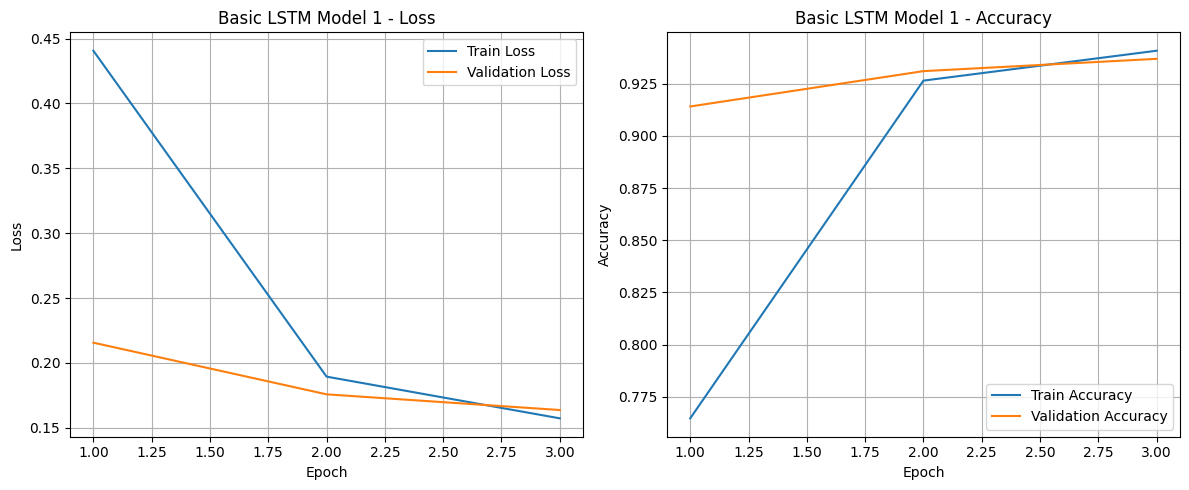

Epoch 1/3 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 1/3 [Validation]:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch [1/3], Train Loss: 0.2993, Train Acc: 0.8570, Val Loss: 0.1860, Val Acc: 0.9266


Epoch 2/3 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 2/3 [Validation]:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch [2/3], Train Loss: 0.1663, Train Acc: 0.9364, Val Loss: 0.1633, Val Acc: 0.9371


Epoch 3/3 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 3/3 [Validation]:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch [3/3], Train Loss: 0.1407, Train Acc: 0.9480, Val Loss: 0.1588, Val Acc: 0.9381


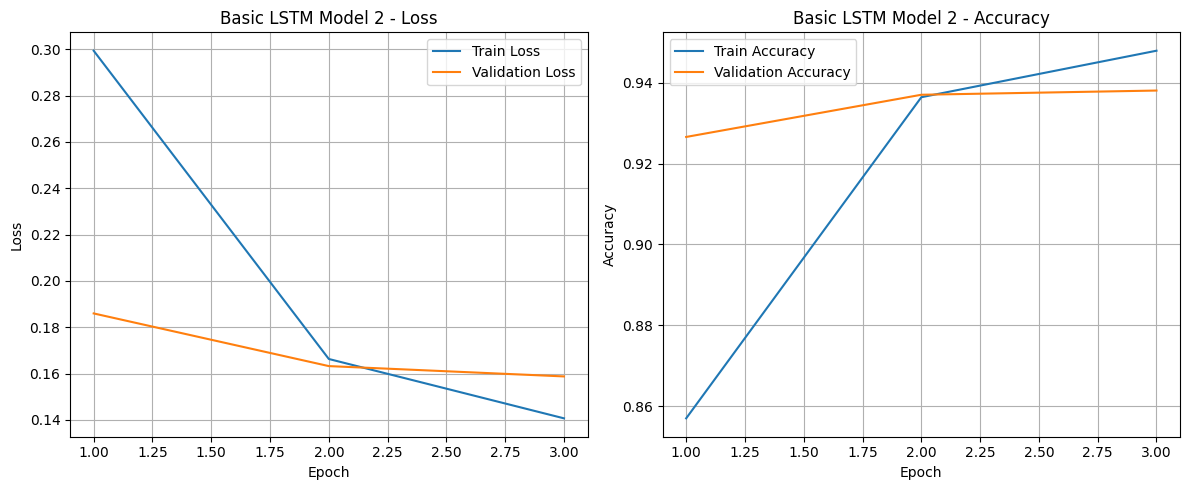

Epoch 1/3 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 1/3 [Validation]:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch [1/3], Train Loss: 0.4302, Train Acc: 0.7669, Val Loss: 0.2201, Val Acc: 0.9126


Epoch 2/3 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 2/3 [Validation]:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch [2/3], Train Loss: 0.1984, Train Acc: 0.9225, Val Loss: 0.1886, Val Acc: 0.9258


Epoch 3/3 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 3/3 [Validation]:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch [3/3], Train Loss: 0.1688, Train Acc: 0.9357, Val Loss: 0.1772, Val Acc: 0.9313


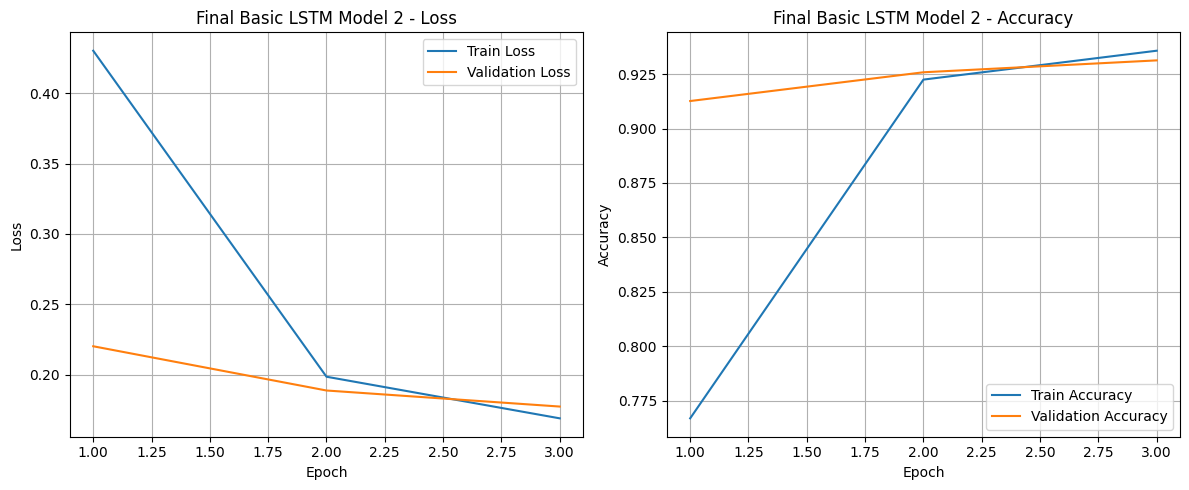

Evaluating Basic LSTM Model 2:   0%|          | 0/157 [00:00<?, ?it/s]

Basic LSTM Model 2 - Test Loss: 0.1754, Test Accuracy: 0.9324


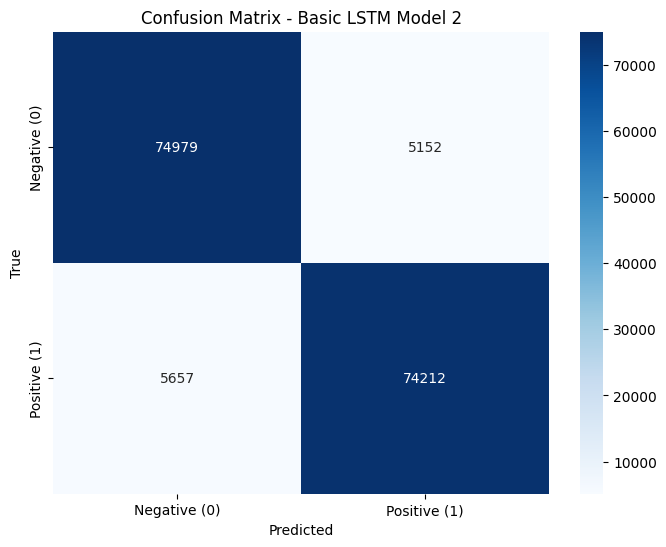

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm
import gc

class BasicLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes, num_layers=3, dropout=0.5):
        super(BasicLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout_layer = nn.Dropout(dropout)
        self.num_layers = num_layers
        self.hidden_size = hidden_size

    def forward(self, x):
        embedded = self.embedding(x)
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(embedded, (h_0, c_0))
        last_hidden_state = out[:, -1, :]
        dropped_out = self.dropout_layer(last_hidden_state)
        logits = self.fc(dropped_out)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, model_name="LSTM Model"):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for texts, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for texts, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    epochs_range = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model_on_test_set(model, test_loader, criterion, device, model_name="Model"):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for texts, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = correct_test / total_test

    print(f'{model_name} - Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative (0)', 'Positive (1)'], yticklabels=['Negative (0)', 'Positive (1)'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    return avg_test_loss, test_accuracy, all_labels, all_predictions

vocab_size = len(vocab)
num_classes = 2
COMMON_NUM_EPOCHS = 3

embed_size_1 = 128
hidden_size_1 = 128
num_layers_1 = 3
dropout_1 = 0.5
learning_rate_1 = 0.001
model_basic_1 = BasicLSTMModel(vocab_size, embed_size_1, hidden_size_1, num_classes, num_layers_1, dropout_1).to(device)
criterion_basic = nn.CrossEntropyLoss()
optimizer_basic_1 = torch.optim.Adam(model_basic_1.parameters(), lr=learning_rate_1)
train_losses_b1, val_losses_b1, train_accuracies_b1, val_accuracies_b1 = train_and_evaluate(model_basic_1, train_loader, val_loader, criterion_basic, optimizer_basic_1, COMMON_NUM_EPOCHS, device, "Basic LSTM Model 1")
del model_basic_1, optimizer_basic_1
gc.collect()
torch.cuda.empty_cache()

embed_size_2 = 128
hidden_size_2 = 256
num_layers_2 = 3
dropout_2 = 0.5
learning_rate_2 = 0.001
model_basic_2 = BasicLSTMModel(vocab_size, embed_size_2, hidden_size_2, num_classes, num_layers_2, dropout_2).to(device)
optimizer_basic_2 = torch.optim.Adam(model_basic_2.parameters(), lr=learning_rate_2)
train_losses_b2, val_losses_b2, train_accuracies_b2, val_accuracies_b2 = train_and_evaluate(model_basic_2, train_loader, val_loader, criterion_basic, optimizer_basic_2, COMMON_NUM_EPOCHS, device, "Basic LSTM Model 2")
del model_basic_2, optimizer_basic_2
gc.collect()
torch.cuda.empty_cache()

basic_models_summary = {
    "Basic LSTM Model 1": val_accuracies_b1[-1],
    "Basic LSTM Model 2": val_accuracies_b2[-1],
}
best_basic_model_name = max(basic_models_summary, key=basic_models_summary.get) 

if best_basic_model_name == "Basic LSTM Model 1":
    best_basic_model = BasicLSTMModel(vocab_size, embed_size_1, hidden_size_1, num_classes, num_layers_1, dropout_1).to(device)
    optimizer_best_basic = torch.optim.Adam(best_basic_model.parameters(), lr=learning_rate_1)
else best_basic_model_name == "Basic LSTM Model 2":
    best_basic_model = BasicLSTMModel(vocab_size, embed_size_2, hidden_size_2, num_classes, num_layers_2, dropout_2).to(device)
    optimizer_best_basic = torch.optim.Adam(best_basic_model.parameters(), lr=learning_rate_2)


train_and_evaluate(best_basic_model, train_loader, val_loader, criterion_basic, optimizer_best_basic, COMMON_NUM_EPOCHS, device, f"Final {best_basic_model_name}")
model_save_path_basic = 'best_basic_lstm_model.pth'
torch.save(best_basic_model.state_dict(), model_save_path_basic)
test_loss_basic, test_accuracy_basic, true_labels_basic, predictions_basic = evaluate_model_on_test_set(best_basic_model, test_loader, criterion_basic, device, best_basic_model_name)
del best_basic_model, optimizer_best_basic
gc.collect()
torch.cuda.empty_cache()


Training a bidirection LSTM with GloVe word embeddings.

100%|█████████▉| 399999/400000 [00:11<00:00, 35369.44it/s]


Epoch 1/3 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 1/3 [Validation]:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch [1/3], Train Loss: 0.4704, Train Acc: 0.7389, Val Loss: 0.2417, Val Acc: 0.9010


Epoch 2/3 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 2/3 [Validation]:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch [2/3], Train Loss: 0.2224, Train Acc: 0.9108, Val Loss: 0.1959, Val Acc: 0.9224


Epoch 3/3 [Train]:   0%|          | 0/1252 [00:00<?, ?it/s]

Epoch 3/3 [Validation]:   0%|          | 0/155 [00:00<?, ?it/s]

Epoch [3/3], Train Loss: 0.1919, Train Acc: 0.9247, Val Loss: 0.1786, Val Acc: 0.9310


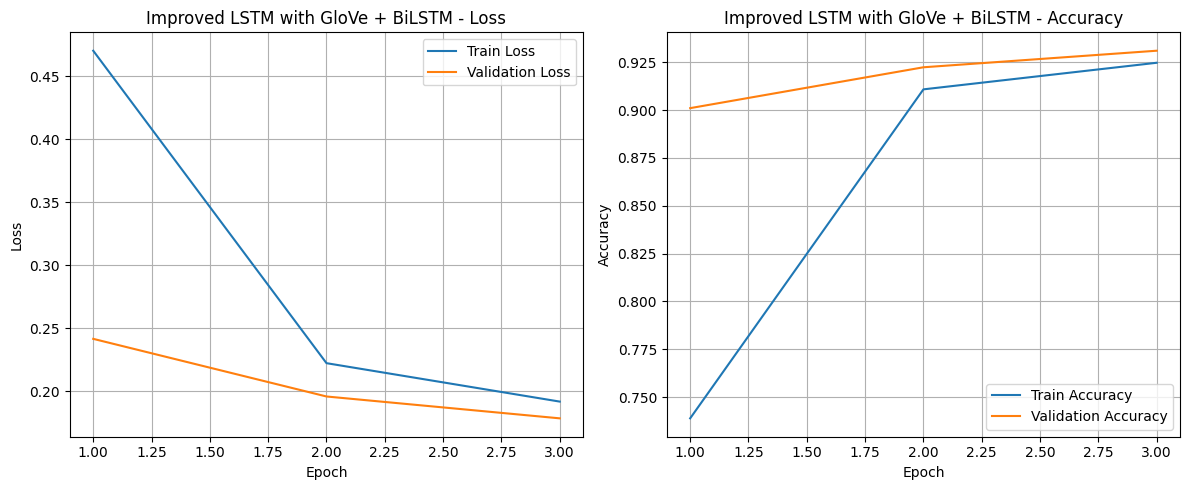

Evaluating Improved LSTM with GloVe + BiLSTM:   0%|          | 0/157 [00:00<?, ?it/s]

Improved LSTM with GloVe + BiLSTM - Test Loss: 0.1774, Test Accuracy: 0.9304


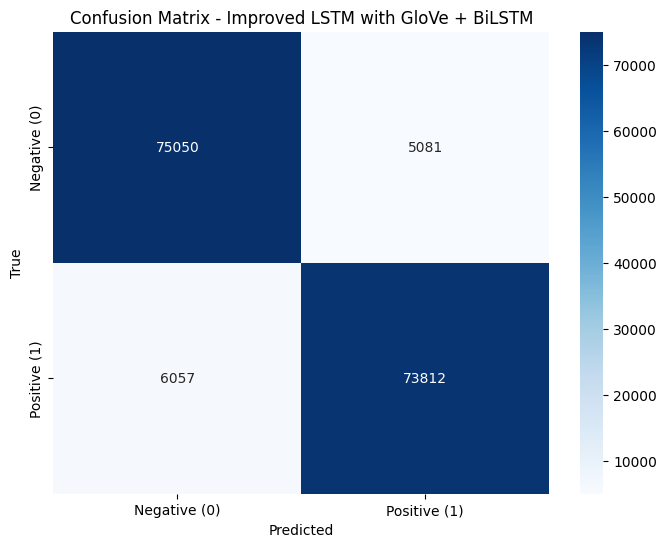

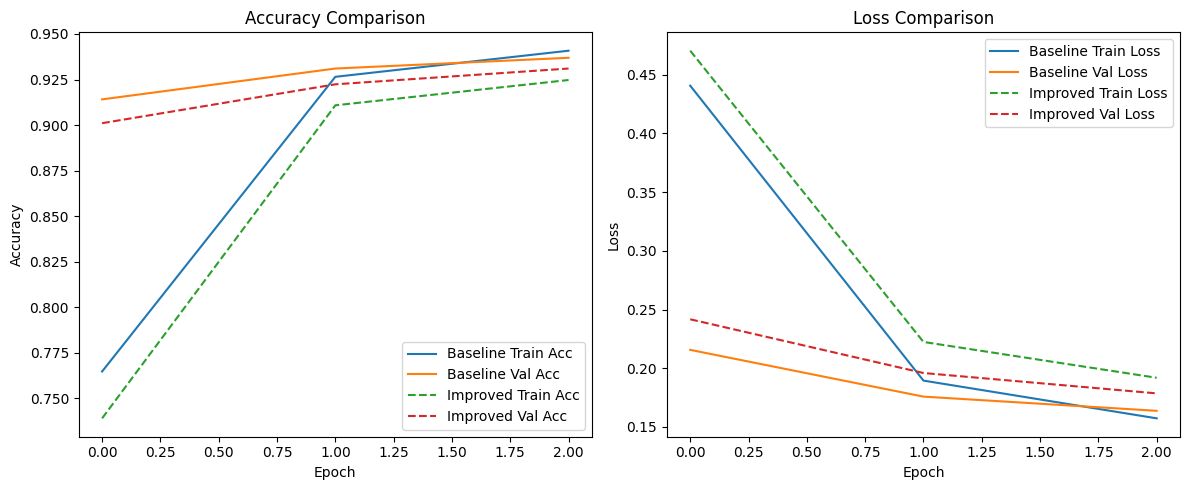

In [14]:
import torch
import torch.nn as nn
from torchtext.vocab import Vectors
import matplotlib.pyplot as plt


def load_glove_embeddings(vocab, glove_path='./glove.6B.100d.txt'):
    vectors = Vectors(name=glove_path)
    embedding_dim = vectors.dim
    pretrained_embeddings = torch.zeros(len(vocab), embedding_dim)
    for i, token in enumerate(vocab.get_itos()):
        if token in vectors.stoi:
            pretrained_embeddings[i] = vectors[token]
        else:
            pretrained_embeddings[i] = torch.randn(embedding_dim)
    return pretrained_embeddings


class ImprovedLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes, num_layers=2, dropout=0.5, bidirectional=True, pretrained_weights=None):
        super(ImprovedLSTMModel, self).__init__()
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embed_size)
        if pretrained_weights is not None:
            self.embedding.weight.data.copy_(pretrained_weights)
            self.embedding.weight.requires_grad = False

        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers,
                            dropout=dropout if num_layers > 1 else 0,
                            batch_first=True,
                            bidirectional=bidirectional)

        self.dropout_layer = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * self.num_directions, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        h_0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(embedded, (h_0, c_0))
        final_state = out[:, -1, :]
        dropped_out = self.dropout_layer(final_state)
        logits = self.fc(dropped_out)
        return logits

glove_embeddings = load_glove_embeddings(vocab)
embed_size = glove_embeddings.shape[1]
hidden_size = 128
num_classes = 2
num_layers = 2
dropout = 0.5

improved_model = ImprovedLSTMModel(len(vocab), embed_size, hidden_size, num_classes,
                                   num_layers=num_layers, dropout=dropout,
                                   bidirectional=True, pretrained_weights=glove_embeddings).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, improved_model.parameters()), lr=0.001)

train_losses_im, val_losses_im, train_acc_im, val_acc_im = train_and_evaluate(
    improved_model, train_loader, val_loader, criterion, optimizer,
    num_epochs=COMMON_NUM_EPOCHS, device=device, model_name="Improved LSTM with GloVe + BiLSTM"
)

test_loss_im, test_acc_im, labels_im, preds_im = evaluate_model_on_test_set(
    improved_model, test_loader, criterion, device,
    model_name="Improved LSTM with GloVe + BiLSTM"
)

torch.save(improved_model.state_dict(), "best_improved_lstm.pth")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies_b1, label='Baseline Train Acc')
plt.plot(val_accuracies_b1, label='Baseline Val Acc')
plt.plot(train_acc_im, label='Improved Train Acc', linestyle='--')
plt.plot(val_acc_im, label='Improved Val Acc', linestyle='--')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses_b1, label='Baseline Train Loss')
plt.plot(val_losses_b1, label='Baseline Val Loss')
plt.plot(train_losses_im, label='Improved Train Loss', linestyle='--')
plt.plot(val_losses_im, label='Improved Val Loss', linestyle='--')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Discusion-
1.The initial steps demonstrated a robust data pipeline, starting with decompression of BZ2 files, loading them into Pandas DataFrames, performing essential text cleaning (lowercasing, removing non-alphanumeric characters), and numeric label mapping. The inclusion of retry logic for file loading and the explicit handling of empty reviews are good practices for data robustness.
2.The initial data statistics and plots confirmed a well-balanced dataset for sentiment classification. The distribution of review lengths indicated a majority of shorter reviews with a long tail, which directly informed the choice of max_length=100 for padding/truncation. The detection of zero-length reviews after cleaning highlights the importance of data quality checks and handling edge cases.
3.The code effectively used torchtext for tokenization (basic_english) and vocabulary construction (min_freq=5), demonstrating the standard workflow for converting raw text into numerical sequences suitable for neural networks. The large vocabulary size (~157k) points to the diversity of language in the dataset and the need for embedding layers.
4.The BasicLSTMModel provides a clear example of a standard PyTorch LSTM for text classification. The train_and_evaluate function, coupled with the loss/accuracy plots, is crucial for monitoring training progress. The consistent observation of validation metrics outperforming training metrics (especially at early epochs) is a common phenomenon in PyTorch due to dropout being active only during training.
5.The comparison between "Basic LSTM Model 1" (hidden_size=128) and "Basic LSTM Model 2" (hidden_size=256) exemplified a basic hyperparameter tuning strategy. Model 2's superior performance (lower loss, higher accuracy) suggested that increased model capacity was beneficial for this dataset, showcasing the importance of finding optimal hyperparameters.
6.The use of a confusion matrix on the test set for the best-performing baseline model provided a granular view of its performance, distinguishing between true positives/negatives and false positives/negatives. This allowed for calculation of precision and recall, offering deeper insights than just overall accuracy and confirming the model's high effectiveness on unseen data.
7.The introduction of pre-trained GloVe embeddings and a bidirectional LSTM (ImprovedLSTMModel) was a logical step for enhancing performance. However, the subsequent training plots revealed that, under the chosen hyperparameters (especially hidden_size=128, num_layers=2, and crucially, frozen embeddings), this "improved" model actually performed worse than the initial basic models.
8.The underperformance of the "improved" model is the most significant learning point. It forcefully demonstrates that simply adding theoretically "better" components (GloVe, BiLSTM) does not guarantee improved results without careful re-tuning of all relevant hyperparameters (e.g., hidden_size, num_layers, learning rate, dropout, and especially whether to fine-tune pre-trained embeddings). This highlights that interactions between architectural components and hyperparameters are complex.
9.The entire sequence of inputs showcases the iterative nature of machine learning model development. From initial data processing to baseline model training, hyperparameter exploration, and then attempting architectural enhancements, each step involves experimentation and empirical validation. The unexpected result from the "improved" model emphasizes that assumptions must always be tested.
10.The progression of experiments illustrates that integrating theoretically "superior" components, such as GloVe embeddings or bidirectional LSTMs, doesn't automatically guarantee performance gains. Instead, the results underscore that the actual efficacy of such enhancements is highly dependent on their meticulous integration and extensive hyperparameter tuning within the specific model architecture and dataset context. This highlights the crucial role of rigorous empirical validation in applied machine learning, where practical performance often deviates from theoretical potential without careful optimization.